In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../data/flipkart_reviews_raw.csv")
df = df[['description', 'overall_rating']].dropna()
df = df.rename(columns={'description': 'review_text', 'overall_rating': 'rating'})

In [7]:
stopwords = ["a", "an", "the", "and", "or", "is", "are", "was", "were", "this", "that", "it", "in", "on",
             "for", "to", "with", "as", "by", "at", "of", "from", "up", "down", "out", "about", "into", "over",
             "after", "again", "further", "then", "once", "here", "there", "all", "any", "both", "each", "few",
             "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
             "too", "very", "can", "will", "just", "don't", "should", "now"]

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stopwords])

df['cleaned_review'] = df['review_text'].apply(clean_text)

In [8]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating'])

df['sentiment'] = df['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
df = df.dropna(subset=['sentiment'])

In [9]:
df_pos = df[df['sentiment'] == 1]
df_neg = df[df['sentiment'] == 0]
df_bal = pd.concat([df_pos.sample(len(df_neg), random_state=42), df_neg])

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_bal['cleaned_review'])
y = df_bal['sentiment']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[34 16]
 [29 27]]
              precision    recall  f1-score   support

         0.0       0.54      0.68      0.60        50
         1.0       0.63      0.48      0.55        56

    accuracy                           0.58       106
   macro avg       0.58      0.58      0.57       106
weighted avg       0.59      0.58      0.57       106



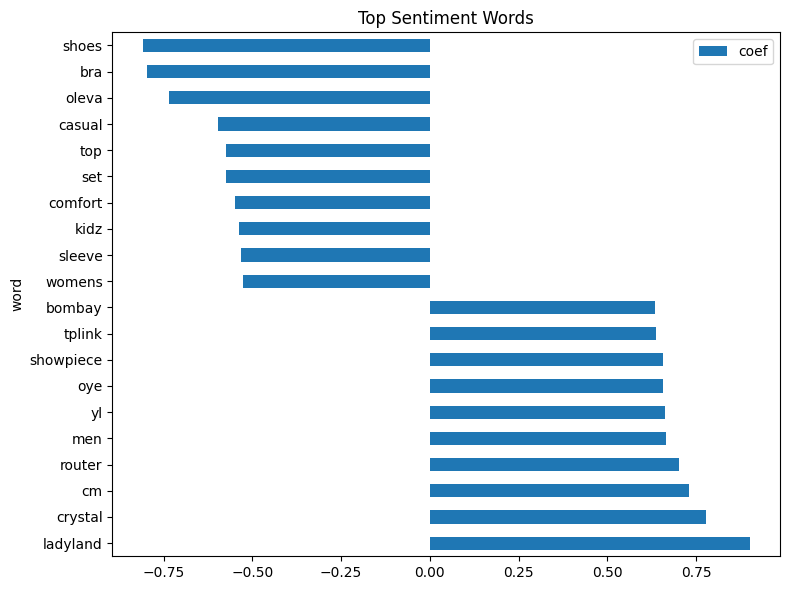

In [13]:
coefs = model.coef_[0]
words = vectorizer.get_feature_names_out()
word_weights = pd.DataFrame({'word': words, 'coef': coefs}).sort_values(by='coef', ascending=False)

top_words = pd.concat([word_weights.head(10), word_weights.tail(10)])
top_words.plot(kind='barh', x='word', y='coef', title='Top Sentiment Words', figsize=(8, 6))
plt.tight_layout()
plt.show()